# A/B Testing: Peeking

Here is something you really shouldn't do when you do A/B testing.

**Situation.** The existing well-studied *drug A* cures a disease in 5 days on average. We'd like to test if the new *drug B* can cure it quicker.

Cases:
- Honest experiment. We test the new drug on 200 patients and compute p-value. If it's below 5%, we report a success.
- Peeking. We're progressively testing the new drug; we stop the exeriment and report a success if p-value is below 5% after any number of patients.

## Setup

In [21]:
import datetime as dt
import itertools
import sys
import warnings

from loguru import logger
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_1samp

import matplotlib.pyplot as plt

np.random.seed(42**3)

In [22]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [23]:
def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

In [24]:
def plot_samples_b(samples_b, mean_a):
    plt.hist(samples_b, bins=20)
    plt.axvline(np.mean(samples_b), c="black", label="mean B")
    plt.axvline(mean_a, c="red", linestyle="--", label="mean A")
    plt.title("Recovery time with the drug B")
    plt.legend()

In [25]:
def generate_means(a, n):
    means = np.empty(n)
    for i in range(n):
        a_empirical = np.random.choice(a, size=len(a))
        means[i] = np.mean(a_empirical)
    return means

def bootstrap_1samp_less(a, popmean, n=500):
    return np.mean(generate_means(a, n) > popmean)

In [26]:
def compute_pvalue_sequence(samples_b, mean_a, method="ttest", min_samples=10):
    p_values = np.zeros(len(samples_b) - min_samples + 1)
    for j in range(len(p_values)):
        if method == "ttest":
            p = ttest_1samp(samples_b[:min_samples + j], mean_a, alternative="less").pvalue
        elif method == "bootstrap":
            p = bootstrap_1samp_less(samples_b[:min_samples + j], mean_a, alternative="less")
        else:
            raise ValueError(f"{method=}")
        p_values[j] = p
    return p_values

def final_pvalue(pvalues, peeking):
    if peeking:
        return np.min(pvalues)
    else:
        return pvalues[-1]
    
def sample_pvalues(n_samples_b, mean_b, mean_a, method="ttest", n_tries=100):
    sampled_pvalues_honest = np.zeros(n_tries)
    sampled_pvalues_peeking = np.zeros(n_tries)
    for i in range(n_tries):
        samples_b = np.random.exponential(mean_b, size=n_samples_b)
        _pvalues = compute_pvalue_sequence(samples_b, mean_a, method=method)
        sampled_pvalues_honest[i] = final_pvalue(_pvalues, peeking=False)
        sampled_pvalues_peeking[i] = final_pvalue(_pvalues, peeking=True)
    return sampled_pvalues_honest, sampled_pvalues_peeking

def experiment_summary(pvalues, alpha):
    plt.hist(pvalues, bins=20)
    plt.title("Sampled p-values")
    plt.axvline(np.median(pvalues), c="black", label="p-value median")
    plt.axvline(alpha, c="red", label="aplha")
    plt.legend()
    print(f"Number of successful experiments = {np.mean(pvalues < alpha):.2f}")

In [27]:
alpha = 0.05  # significance level

## Drug B is more effective

- Honest experiment: 93% of (correctly reported) successes
- Experiment with peeking: 98% (correctly reported) of successes

In [28]:
mean_a = 5
mean_b = 4
n_samples = 200

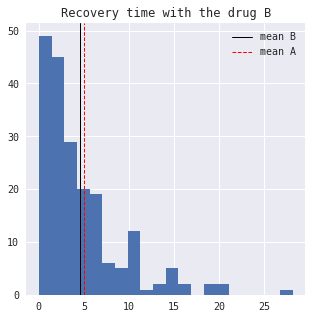

In [29]:
plot_samples_b(np.random.exponential(mean_b, size=n_samples), mean_a)

--- Honest experiments ---
Number of successful experiments = 0.93


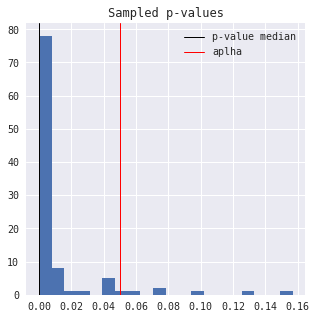

In [30]:
print("--- Honest experiments ---")
pvalues_honest, pvalues_peeking = sample_pvalues(n_samples, mean_b, mean_a)
experiment_summary(pvalues_honest, alpha)

--- Experiments with peeking ---
Number of successful experiments = 0.98


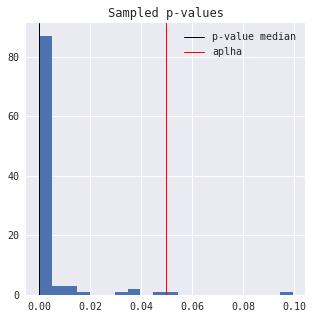

In [31]:
print("--- Experiments with peeking ---")
experiment_summary(pvalues_peeking, alpha)

## Drugs A and B are equally effective

- Honest experiment: 6% of (incorrectly reported) successes
- Experiment with peeking: 43% (incorrectly reported) of successes

In [32]:
mean_a = 5
mean_b = 5
n_samples = 200

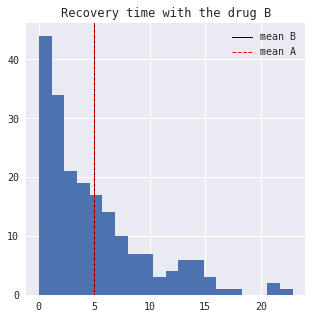

In [33]:
plot_samples_b(np.random.exponential(mean_b, size=n_samples), mean_a)

--- Honest experiments ---
Number of successful experiments = 0.06


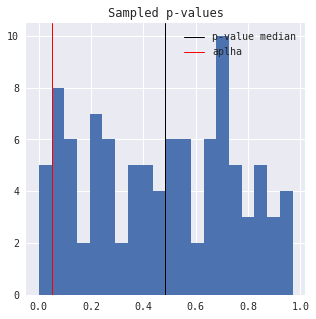

In [34]:
print("--- Honest experiments ---")
pvalues_honest, pvalues_peeking = sample_pvalues(n_samples, mean_b, mean_a)
experiment_summary(pvalues_honest, alpha)

--- Experiments with peeking ---
Number of successful experiments = 0.43


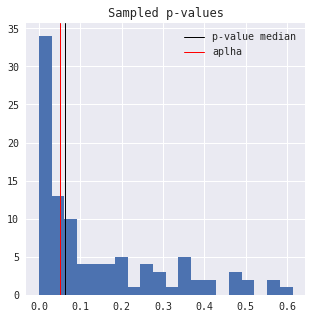

In [35]:
print("--- Experiments with peeking ---")
experiment_summary(pvalues_peeking, alpha)

## Drug B is less effective

- Honest experiment: 0% of (incorrectly reported) successes
- Experiment with peeking: 13% (incorrectly reported) of successes

In [36]:
mean_a = 5
mean_b = 6
n_samples = 200

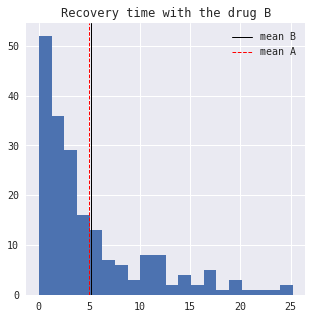

In [37]:
plot_samples_b(np.random.exponential(mean_b, size=n_samples), mean_a)

--- Honest experiments ---
Number of successful experiments = 0.00


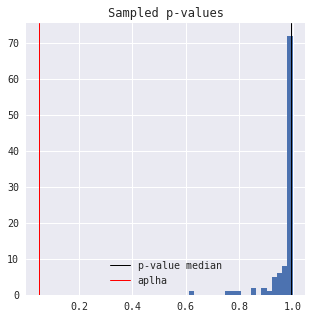

In [38]:
print("--- Honest experiments ---")
pvalues_honest, pvalues_peeking = sample_pvalues(n_samples, mean_b, mean_a)
experiment_summary(pvalues_honest, alpha)

--- Experiments with peeking ---
Number of successful experiments = 0.13


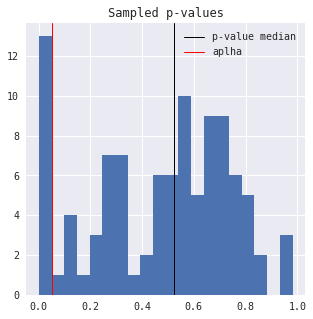

In [39]:
print("--- Experiments with peeking ---")
experiment_summary(pvalues_peeking, alpha)